# EDS 220 Fall 2022
# Data Regridding

Let's get some practice working with interpolation and data regridding! We'll be working with the same SST datasets used in other notebooks, just to make things easier.

__NOTE: the selection of the correct Python kernel is important!__

we'll be using the OpeNDAP interface to grab some of the data, so the same caveats with regards to Taylor or your personal Python install apply as they did previously. To avoid issues, do one of the following:

* On Taylor - make sure that 'Anaconda Base' is selected as your kernel;

* On a local Python install - make sure that you have installed all of the packages `xarray`, `libnetcdf`, and `netcdf4` 
  (you'll likely need to use conda to install the latter two)

Import packages first:

In [10]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

### 1) Read in data

To demonstrate the process of converting two-dimensional data to a common grid, we'll use two gridded climate data products:

* The [NOAA Extended Reconstructed Sea Surface Temperature version 5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) (ERSSTv5)
* The [Global Precipitation Climatology Product](https://psl.noaa.gov/data/gridded/data.gpcp.html) (GPCP)

Both of these data sets have relatively low spatial resolution: roughly 2 degrees on a side in lat and lon. This makes them quick to load over OpeNDAP. But the locations of the data points are not the same, meaning that to directly compare we need to do our regridding exercise!

First, load the data using the remote OpeNDAP URLs:

In [5]:
# location of ERSSTv5 data
ersst_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"

# open dataset using remote URL
ersst=xr.open_dataset(ersst_url,drop_variables="time_bnds")

# display dataset to see what it looks like
ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2025)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-09-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-10-04
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
# Location of precipitation dataset
gpcp_url="https://psl.noaa.gov/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc"

# open dataset with remote URL
gpcp=xr.open_dataset(gpcp_url,drop_variables="time_bnds")

# display dataset to see what it looks like
gpcp

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 525)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-09-01
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (lat, nv) float32 ...
    lon_bnds  (lon, nv) float32 ...
    precip    (time, lat, lon) float32 ...
Attributes: (12/19)
    Conventions:                     CF-1.0
    curator:                         Dr. Jian-Jian Wang\nESSIC, University of...
    citation:                        Adler, R.F., G.J. Huffman, A. Chang, R. ...
    title:                           GPCP Version 2.3 Combined Precipitation ...
    platform:                        NOAA POES (Polar Orbiting Environmental ...
    source_obs:                      CDR RSS SSMI/SSMIS Tbs over ocean \nCDR ...
    ...                              ...
    source_documentation:            https://www.ncdc.noaa.gov/cdr/atmospheri...
    NCO:                             4.6.9
    history:                         Generated at NOAA/ESRL PSD Sep 9 2016 ba...
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    data_comment:                    Interim data covers 2022/08 through latest.
    DODS_EXTRA.Unlimited_Dimension:  time

To get a visual sense of how the data products are laid out spatially, we can create plots using Matplotlib's `pcolor`. If we wanted to create a production-quality plot, using a map projection with Cartopy would be necessary, but here we're just looking for a quick overview:

<ipython-input-18-9ec733d156e2>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(ersst['lon'],ersst['lat'],ersst_timeavg)


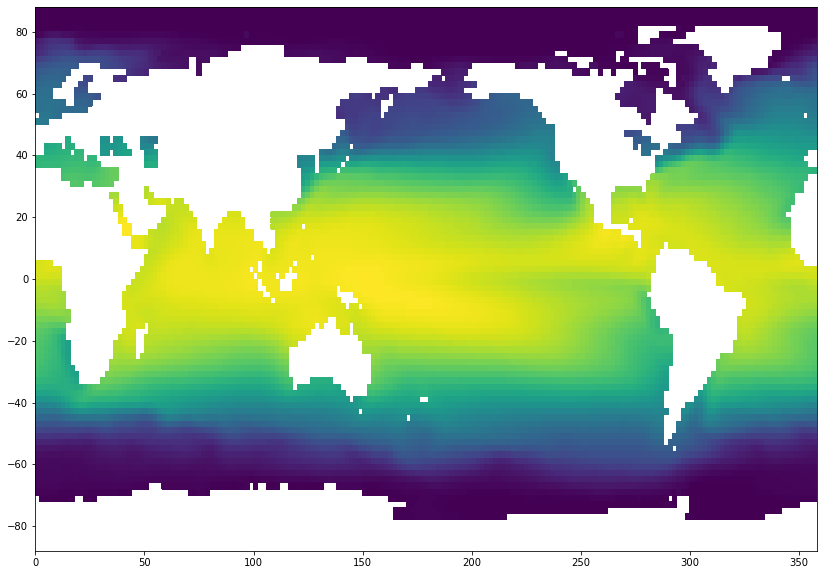

In [18]:
# Take time average of ERSST data
ersst_timeavg=ersst['sst'].mean(dim='time')

# Create a blank figure
plt.figure(figsize=(14,10))
# Plot ERSST time average
plt.pcolor(ersst['lon'],ersst['lat'],ersst_timeavg)

<ipython-input-20-1479dbca0d50>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(gpcp['lon'],gpcp['lat'],gpcp_timeavg)


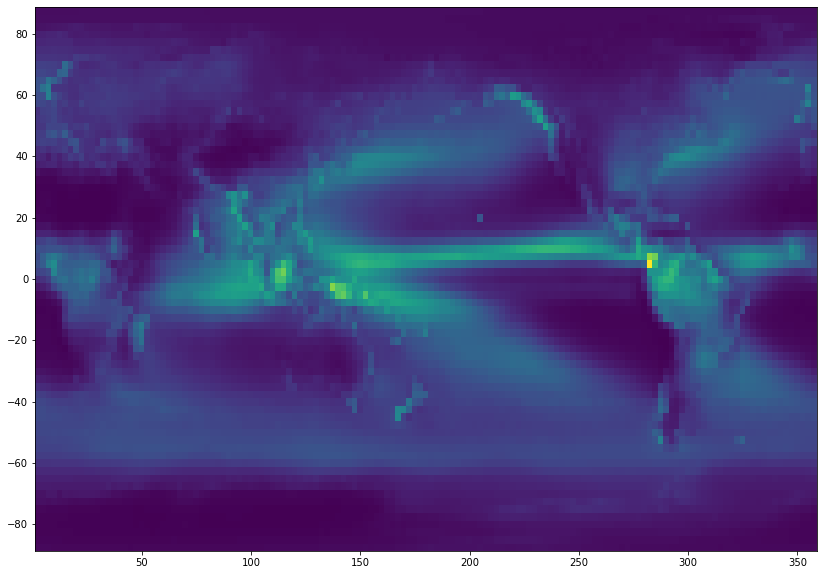

In [20]:
# Take time average of GPCP data
gpcp_timeavg=gpcp['precip'].mean(dim='time')

# Create a blank figure
plt.figure(figsize=(14,10))
# Plot GPCP time average
plt.pcolor(gpcp['lon'],gpcp['lat'],gpcp_timeavg)

It should be clear that there are differences between these datasets: they're entirely different variables, with different spatial coverages, and slightly different resolutions. Now let's put them on a common grid!

In [19]:
# Interpolate SST to GPCP grid
ersst_int = ersst_timeavg.interp(lat=gpcp.lat, lon=gpcp.lon)

In [21]:
# Display header info for interpolated ERSST
ersst_int

<xarray.DataArray 'sst' (lat: 72, lon: 144)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.7994221, -1.7985431, -1.7967384, ..., -1.7988123, -1.79945  ,
               nan],
       [-1.7998478, -1.7998359, -1.7998302, ..., -1.7999719, -1.7999004,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

<ipython-input-22-7a20c987c39b>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(ersst_int['lon'],ersst_int['lat'],ersst_int)


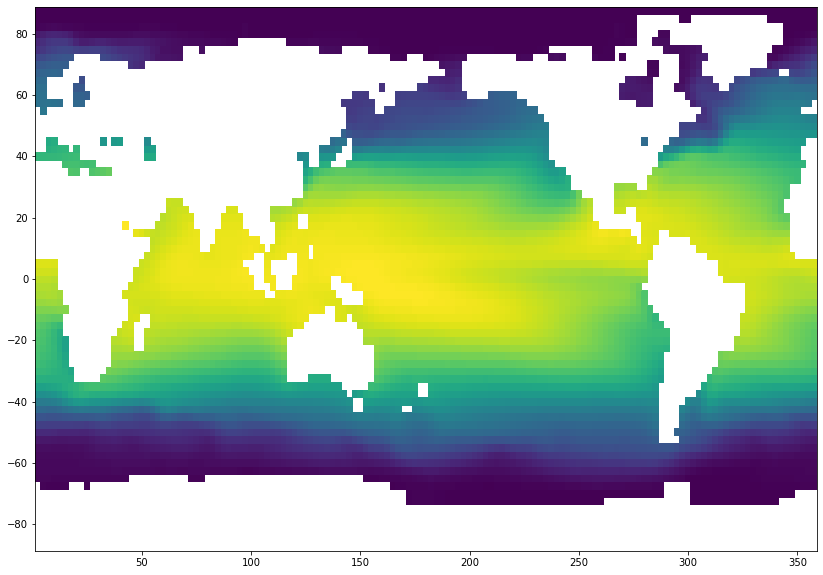

In [22]:
# Create a blank figure
plt.figure(figsize=(14,10))
# Plot interpolated SST
plt.pcolor(ersst_int['lon'],ersst_int['lat'],ersst_int)